## Entity Relationship Diagram


In [1]:
from dataclasses import dataclass
from gvdot import Dot

The Graphviz Gallery includes [a Chen-style entity relationship
diagram](https://graphviz.org/Gallery/neato/ER.html).  

We can reproduce that example by transcribing the gallery's [DOT language input
file](https://graphviz.org/Gallery/neato/ER.gv.txt) to gvdot calls.

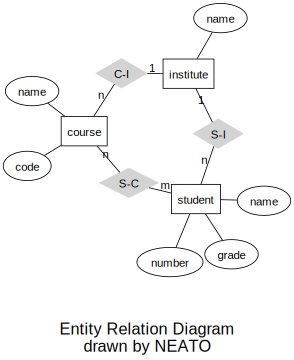

In [2]:
dot = Dot().graph(layout="neato")
dot.all_default(fontname="Helvetica,Arial,sans-serif")

dot.node_role("entity",shape="box")
dot.node_role("attribute",shape="ellipse")
dot.node_role("relationship",shape="diamond",style="filled",color="lightgrey")

dot.node('course', role="entity")
dot.node('institute', role="entity")
dot.node('student', role="entity")

dot.node('name0', label='name', role="attribute")
dot.node('name1', label='name', role="attribute")
dot.node('name2', label='name', role="attribute")

dot.node('code', role="attribute")
dot.node('grade', role="attribute")
dot.node('number', role="attribute")

dot.node('C-I', role="relationship")
dot.node('S-C', role="relationship")
dot.node('S-I', role="relationship")

dot.edge('name0', 'course')
dot.edge('code', 'course')
dot.edge('course', 'C-I', label='n', len=1.0)
dot.edge('C-I', 'institute', label='1', len=1.0)
dot.edge('institute', 'name1')
dot.edge('institute', 'S-I', label='1', len=1.0)
dot.edge('S-I', 'student', label='n', len=1.0)
dot.edge('student', 'grade')
dot.edge('student', 'name2')
dot.edge('student', 'number')
dot.edge('student', 'S-C', label='m', len=1.0)
dot.edge('S-C', 'course', label='n', len=1.0)

dot.graph(fontsize=20, label='\n\nEntity Relation Diagram\ndrawn by NEATO')

dot.show(size="5,5")

Aside from method calls instead of DOT statements, the primary difference
between the original DOT file and the transcription is that the DOT file
restates node defaults three times to reduce explicit attribute value
assignments, while the code uses gvdot roles.  

Restating defaults is convenient when writing DOT by hand, but it can be
awkward when programmatically generating DOT directly because it forces code to
group together nodes and edges in a way that may be inconsistent with the
structure of the code's input. Hence, gvdot's order independence and roles.

Suppose we want to generate diagrams from ER models represented by the
following classes.

In [3]:
@dataclass
class Entity:
    name : str
    attributes : list[str]

@dataclass
class Participant:
    entity : str
    cardinality : str

@dataclass
class Relationship:
    name : str
    participants : list[Participant]

@dataclass
class Model:
    entities : list[Entity]
    relationships : list[Relationship]

Let's create a model based on the gallery example.

In [4]:
example_model = Model(
    entities = [
        Entity("course",["name","code"]),
        Entity("institute",["name"]),
        Entity("student",["name","number","grade"]),
    ],
    relationships = [
        Relationship("C-I",[
            Participant("course","n"),
            Participant("institute","1")]),
        Relationship("S-I",[
            Participant("institute","1"),
            Participant("student","n")]),
        Relationship("S-C",[
            Participant("course","n"),
            Participant("student","m"),
        ])
    ])

Chen ER-diagrams use rectangles for entities, ellipses for attributes, and
diamonds for relationships.  We define an ER-diagram theme with those shapes.
We also choose the same font and layout engine as the gallery, and define edge
roles as well.

In [5]:
er_base_theme = (Dot()
.graph(layout="neato")
.all_default(fontname="Helvetica,Arial,sans-serif")
.node_role("entity", shape="box")
.node_role("attribute", shape="ellipse")
.node_role("relationship", shape="diamond")
.edge_role("e-to-r", len=1.0)
.edge_role("a-to-e")
)

Themes can inherit from other themes.  The gallery example uses a solid light
gray for relationships, so we specialize the theme a bit.

In [6]:
er_gallery_theme = (Dot().use_theme(er_base_theme)
.node_role("relationship", style="filled", color="lightgrey")
)

Now we write our code to generate diagrams from models.  Observe there are no
presentation-related attribute assignments.  We could have them, of course, but
relying on roles and defaults from the theme keeps the code simple and easy to
maintain.  

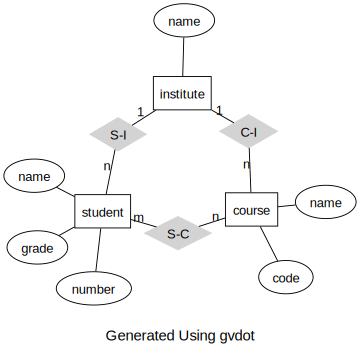

In [7]:
def er_diagram(model:Model, title:str, theme:Dot) -> Dot:
    dot = Dot().use_theme(theme)
    attribute_id = 0
    for entity in model.entities:
        dot.node(entity.name, role="entity")
        for attribute in entity.attributes:
            dot.node(attribute_id, role="attribute", label=attribute)
            dot.edge(entity.name, attribute_id, role="a-to-e")
            attribute_id += 1
    for relationship in model.relationships:
        dot.node(relationship.name, role="relationship")
        for participant in relationship.participants:
            dot.edge(relationship.name,participant.entity,
                     label=participant.cardinality, role="e-to-r")
    dot.graph(fontsize=16, label=f"\n{title}")
    return dot

diagram = er_diagram(example_model, "Generated Using gvdot", er_gallery_theme)
diagram.show(size="5,5")

We get the same diagram as the transcribed version earlier.  (The layout may
differ because neato's algorithm is affected by DOT statement order.)  If we
examine the DOT language representation of the diagram, we can see how the
theme defaults and roles were incorporated.

In [8]:
diagram.show_source()

graph {

    graph [fontname="Helvetica,Arial,sans-serif"]
    node [fontname="Helvetica,Arial,sans-serif"]
    edge [fontname="Helvetica,Arial,sans-serif"]

    layout=neato
    fontsize=16

    course [shape=box]
    0 [label="name" shape=ellipse]
    1 [label="code" shape=ellipse]
    institute [shape=box]
    2 [label="name" shape=ellipse]
    student [shape=box]
    3 [label="name" shape=ellipse]
    4 [label="number" shape=ellipse]
    5 [label="grade" shape=ellipse]
    "C-I" [shape=diamond style=filled color=lightgrey]
    "S-I" [shape=diamond style=filled color=lightgrey]
    "S-C" [shape=diamond style=filled color=lightgrey]

    course -- 0
    course -- 1
    institute -- 2
    student -- 3
    student -- 4
    student -- 5
    "C-I" -- course [label="n" len=1.0]
    "C-I" -- institute [label="1" len=1.0]
    "S-I" -- institute [label="1" len=1.0]
    "S-I" -- student [label="n" len=1.0]
    "S-C" -- course [label="n" len=1.0]
    "S-C" -- student [label="m" len=1.0]

    label="\nGenerated Using gvdot"
}

The gallery theme is quite plain looking.  Let's render something with color.
All we need to do is change the theme – we don't even need to rebuild the
diagram.

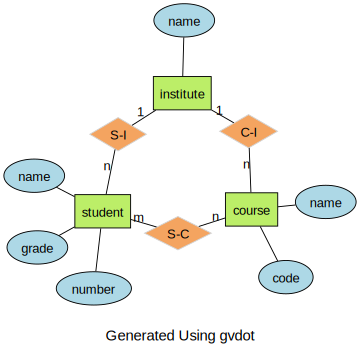

In [9]:
er_color_theme = (Dot().use_theme(er_base_theme)
.node_role("entity",style="filled",fillcolor="darkolivegreen2")
.node_role("attribute",style="filled",fillcolor="lightblue")
.node_role("relationship",style="filled",fillcolor="sandybrown")
)

diagram.use_theme(er_color_theme)
diagram.show(size="5,5")


Much nicer.  Let's save this one.

In [10]:
with open("er-diagram.svg","w") as f:
    print(diagram.to_svg(), file=f)